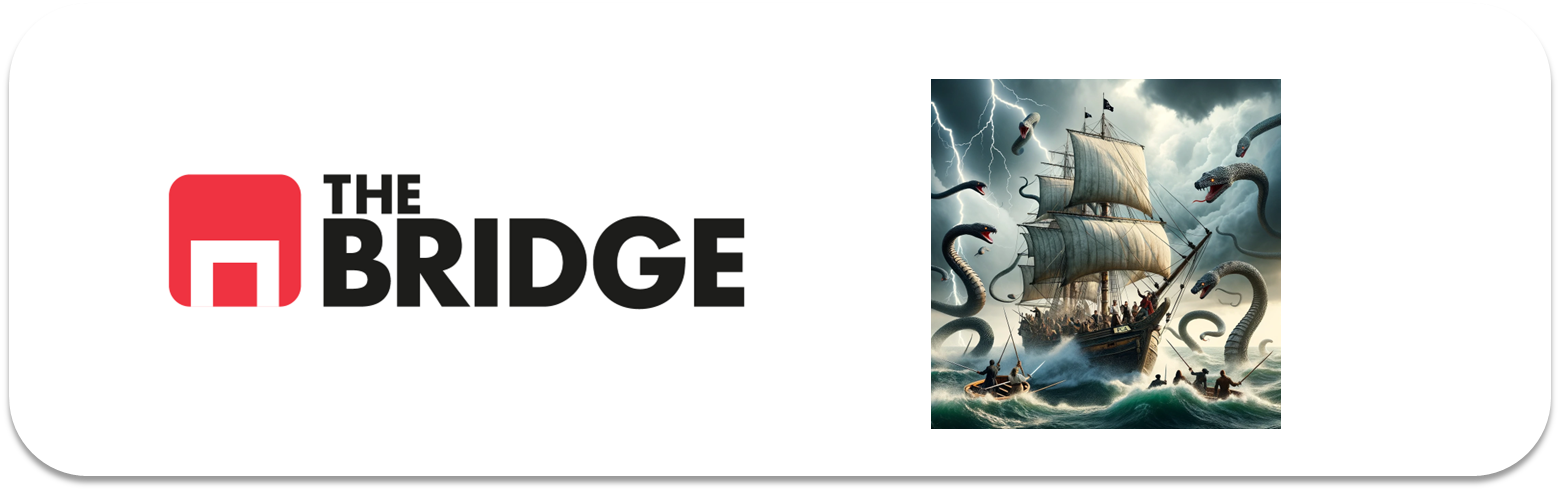

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

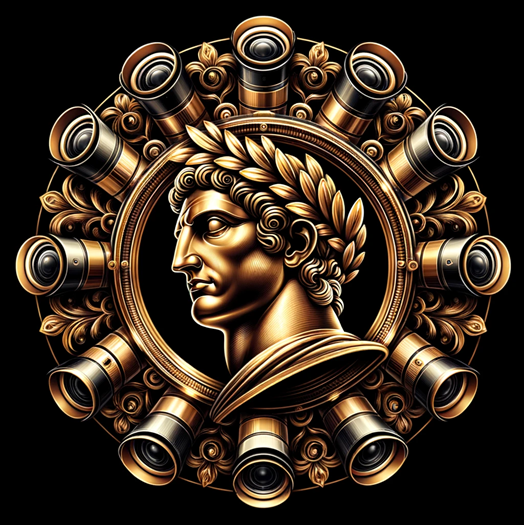

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import balanced_accuracy_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [3]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
df=pd.DataFrame(faces.data)
df['target'] = faces.target
df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.400826,0.495868,0.570248,0.632231,0.648760,0.640496,0.661157,0.636364,0.665289,0.698347,...,0.396694,0.264463,0.099174,0.181818,0.243802,0.247934,0.161157,0.157025,0.136364,39
396,0.367769,0.367769,0.351240,0.301653,0.247934,0.247934,0.367769,0.512397,0.574380,0.628099,...,0.334711,0.289256,0.285124,0.338843,0.404959,0.458678,0.487603,0.512397,0.549587,39
397,0.500000,0.533058,0.607438,0.628099,0.657025,0.632231,0.657025,0.669421,0.673554,0.702479,...,0.148760,0.152893,0.161157,0.161157,0.173554,0.157025,0.177686,0.148760,0.190083,39
398,0.214876,0.219008,0.219008,0.223140,0.210744,0.202479,0.276859,0.400826,0.487603,0.549587,...,0.392562,0.367769,0.409091,0.479339,0.524793,0.545455,0.574380,0.590909,0.603306,39


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1), 
    df['target'],               
    test_size=0.2,              
    stratify=df['target'],      
    random_state=42             
)

In [5]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(random_state= 42)

In [17]:
random.fit(X_train, y_train) 
y_pred=random.predict(X_train)
baseline_cv=np.mean(cross_val_score(random, X_train, y_train, cv = 5, scoring= "balanced_accuracy"))
print("Recall medio:", np.mean(cross_val_score(random, X_train, y_train, cv = 5, scoring= "balanced_accuracy")))

Recall medio: 0.9349999999999999


In [19]:
baseline_test=recall_score(y_test,random.predict(X_test),average="macro")

In [7]:
print(classification_report(y_test, random.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          16       1.00      1.00      1.00         2
          17       0.67    

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [8]:
#1
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
pca.explained_variance_ratio_.cumsum()

array([0.23813324, 0.36946237, 0.4531552 , 0.50389934, 0.54082537,
       0.5733734 , 0.5975542 , 0.6184816 , 0.63774323, 0.6546737 ,
       0.6705587 , 0.6852649 , 0.69815856, 0.7102453 , 0.721577  ,
       0.7311504 , 0.739924  , 0.7484213 , 0.75619745, 0.7636284 ,
       0.77095926, 0.7773812 , 0.783356  , 0.78905064, 0.79466647,
       0.8001132 , 0.805301  , 0.81030816, 0.8151073 , 0.81967175,
       0.8240366 , 0.8280795 , 0.8318868 , 0.83535427, 0.83874553,
       0.8420229 , 0.8452384 , 0.84839934, 0.8513041 , 0.85416734,
       0.85694057, 0.85961485, 0.86216134, 0.8646439 , 0.86709595,
       0.8694816 , 0.8718445 , 0.8741369 , 0.87629354, 0.87839854,
       0.88041353, 0.8823954 , 0.884337  , 0.88623834, 0.8881127 ,
       0.88991934, 0.8916903 , 0.89343506, 0.89514077, 0.8968169 ,
       0.89844435, 0.90005136, 0.9015984 , 0.9030913 , 0.904573  ,
       0.90599793, 0.9074135 , 0.9088116 , 0.9101937 , 0.911545  ,
       0.9128809 , 0.91415393, 0.9154199 , 0.91664153, 0.91785

In [10]:
pca.components_.shape

(320, 4096)

In [11]:
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
for i, var_acum in enumerate(prop_varianza_acum, 1):
    print(f"Componente {i}: {var_acum:.2f}")


Componente 1: 0.24
Componente 2: 0.37
Componente 3: 0.45
Componente 4: 0.50
Componente 5: 0.54
Componente 6: 0.57
Componente 7: 0.60
Componente 8: 0.62
Componente 9: 0.64
Componente 10: 0.65
Componente 11: 0.67
Componente 12: 0.69
Componente 13: 0.70
Componente 14: 0.71
Componente 15: 0.72
Componente 16: 0.73
Componente 17: 0.74
Componente 18: 0.75
Componente 19: 0.76
Componente 20: 0.76
Componente 21: 0.77
Componente 22: 0.78
Componente 23: 0.78
Componente 24: 0.79
Componente 25: 0.79
Componente 26: 0.80
Componente 27: 0.81
Componente 28: 0.81
Componente 29: 0.82
Componente 30: 0.82
Componente 31: 0.82
Componente 32: 0.83
Componente 33: 0.83
Componente 34: 0.84
Componente 35: 0.84
Componente 36: 0.84
Componente 37: 0.85
Componente 38: 0.85
Componente 39: 0.85
Componente 40: 0.85
Componente 41: 0.86
Componente 42: 0.86
Componente 43: 0.86
Componente 44: 0.86
Componente 45: 0.87
Componente 46: 0.87
Componente 47: 0.87
Componente 48: 0.87
Componente 49: 0.88
Componente 50: 0.88
Component

In [12]:
# Para 0.2% compresión -> pcas necesito, 4096 de partida 0.2,0.5,1,2
num_pca = 0.2/100 * 4096
num_pca

8.192

In [13]:
compresion_maxima = 0.2
compresion_minima = 2.5
num_pcas = []
num_features = len(X_train.columns) # Si son 4096, por florear un poco
for rango in np.linspace(compresion_maxima, compresion_minima, 10):
    # grado compresion = num_pca/num_features * 100 -> num_pca = grado_compresion * num_features / 100
    num_pca = int(rango * num_features/100)
    print(f"Para {rango}% de compresión, voy a probar {num_pca} PCs")
    num_pcas.append(num_pca)
print("Rangos que voy a probar:")
print(num_pcas)

Para 0.2% de compresión, voy a probar 8 PCs
Para 0.45555555555555555% de compresión, voy a probar 18 PCs
Para 0.711111111111111% de compresión, voy a probar 29 PCs
Para 0.9666666666666666% de compresión, voy a probar 39 PCs
Para 1.222222222222222% de compresión, voy a probar 50 PCs
Para 1.4777777777777776% de compresión, voy a probar 60 PCs
Para 1.7333333333333332% de compresión, voy a probar 70 PCs
Para 1.9888888888888887% de compresión, voy a probar 81 PCs
Para 2.2444444444444445% de compresión, voy a probar 91 PCs
Para 2.5% de compresión, voy a probar 102 PCs
Rangos que voy a probar:
[8, 18, 29, 39, 50, 60, 70, 81, 91, 102]


In [15]:
X_train_pca.shape

(320, 320)

In [20]:
lista_valores = []
rf_clf = RandomForestClassifier(random_state = 42)
for num_pca in num_pcas:
    X_train_temp = X_train_pca[:,:num_pca] # 
    X_test_temp = X_test_pca[:, :num_pca]
    eval_cv = np.mean(cross_val_score(rf_clf, X_train_temp, y_train, cv = 5, scoring = "balanced_accuracy"))
    rf_clf.fit(X_train_temp, y_train)
    y_pred = rf_clf.predict(X_test_temp)
    eval_test = recall_score(y_test, y_pred, average = "macro")
    datos = {
        "num_pca": num_pca,
        "factor compresión": round(num_pca/num_features*100,2),
        "eval_cv": eval_cv * 100,
        "baseline_cv": baseline_cv * 100,
        "diff_cv": (baseline_cv - eval_cv) * 100,
        "eval_test": eval_test * 100,
        "baseline_test": baseline_test * 100,
        "diff_test": (baseline_test - eval_test) * 100
    }
    lista_valores.append(datos.copy())

In [21]:
df_resultados = pd.DataFrame(lista_valores)
df_resultados

,num_pca,factor compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
0,8,0.20,80.50,93.5,13.00,77.50,95.0,17.50
1,18,0.44,91.75,93.5,1.75,90.00,95.0,5.00
2,29,0.71,91.75,93.5,1.75,91.25,95.0,3.75
3,39,0.95,91.75,93.5,1.75,93.75,95.0,1.25
4,50,1.22,89.25,93.5,4.25,87.50,95.0,7.50
5,60,1.46,91.75,93.5,1.75,91.25,95.0,3.75
6,70,1.71,92.00,93.5,1.50,92.50,95.0,2.50
7,81,1.98,91.00,93.5,2.50,88.75,95.0,6.25
8,91,2.22,89.00,93.5,4.50,91.25,95.0,3.75
9,102,2.49,88.50,93.5,5.00,90.00,95.0,5.00


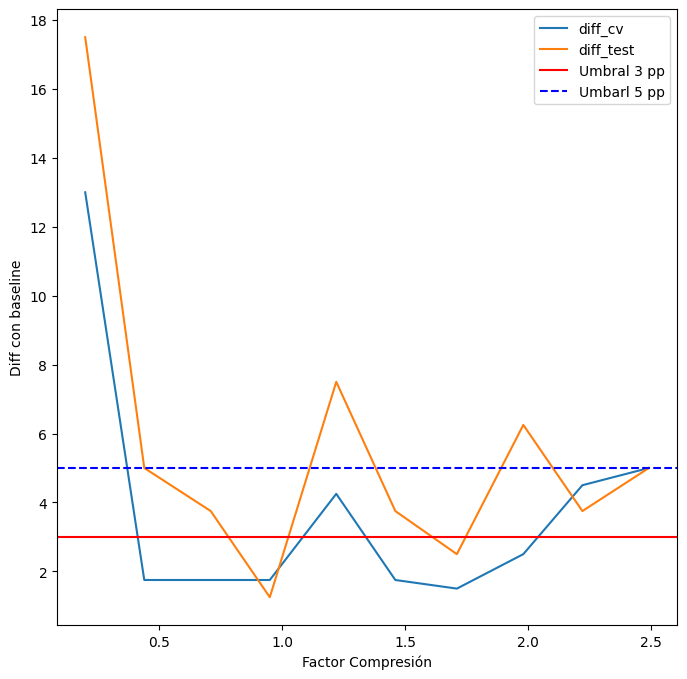

In [22]:
plt.figure(figsize=(8,8))
umbral_corte_1 = 3
umbral_corte_2 = 5
for lineas in ["diff_cv","diff_test"]:
    plt.plot(df_resultados["factor compresión"], df_resultados[lineas], label = lineas)
plt.xlabel("Factor Compresión")
plt.ylabel("Diff con baseline")
plt.axhline(y = umbral_corte_1, color = 'r', linestyle = '-', label = f"Umbral {umbral_corte_1} pp")
plt.axhline(y = umbral_corte_2, color = "b", linestyle = "--",label = f"Umbarl {umbral_corte_2} pp")

plt.legend()

In [23]:
cumple_umbral_1 = (df_resultados["diff_cv"] <= umbral_corte_1) & (df_resultados["diff_test"] <= umbral_corte_1)
df_resultados[cumple_umbral_1]

,num_pca,factor compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
3,39,0.95,91.75,93.5,1.75,93.75,95.0,1.25
6,70,1.71,92.00,93.5,1.50,92.50,95.0,2.50


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [24]:
compresion_maxima = 0.1
compresion_minima = 1
num_pcas = []
num_features = len(X_train.columns) # Si son 4096, por florear un poco
for rango in np.linspace(compresion_maxima, compresion_minima, 10):
    # grado compresion = num_pca/num_features * 100 -> num_pca = grado_compresion * num_features / 100
    num_pca = int(rango * num_features/100)
    num_pcas.append(num_pca)
print("Rangos que voy a probar:")
print(num_pcas)

Rangos que voy a probar:
[4, 8, 12, 16, 20, 24, 28, 32, 36, 40]


In [25]:


lista_valores = []
rf_clf = RandomForestClassifier(random_state = 42)
for num_pca in num_pcas:
    pca_temp = PCA(num_pca) # Por una cuestión de funcionamiento de la clase PCA tenemos que "comprimir" de nuevo no podemos usar el X_train_pca directamente
    X = pca_temp.fit_transform(X_train)
    X_t = pca_temp.transform(X_test)
    X_train_temp = pca_temp.inverse_transform(X) # AQUI ESTA LA CLAVE, primero nos quedamos con el dataset pequeño y luego "descomprimimos"
    print("num pcas:", num_pca, "num features descomprimdas: ", X_train_temp.shape[1])
    X_test_temp = pca_temp.inverse_transform(X_t) # APLICAMOS lo mismo a test
    eval_cv = np.mean(cross_val_score(rf_clf, X_train_temp, y_train, cv = 5, scoring = "balanced_accuracy"))
    rf_clf.fit(X_train_temp, y_train)
    y_pred = rf_clf.predict(X_test_temp)
    eval_test = recall_score(y_test, y_pred, average = "macro")
    datos = {
        "num_pca": num_pca,
        "factor compresión": round(num_pca/num_features*100,2),
        "eval_cv": eval_cv * 100,
        "baseline_cv": baseline_cv * 100,
        "diff_cv": (baseline_cv - eval_cv) * 100,
        "eval_test": eval_test * 100,
        "baseline_test": baseline_test * 100,
        "diff_test": (baseline_test - eval_test) * 100
    }
    lista_valores.append(datos.copy())

df_resultados = pd.DataFrame(lista_valores)
df_resultados

num pcas: 4 num features descomprimdas:  4096
num pcas: 8 num features descomprimdas:  4096
num pcas: 12 num features descomprimdas:  4096
num pcas: 16 num features descomprimdas:  4096
num pcas: 20 num features descomprimdas:  4096
num pcas: 24 num features descomprimdas:  4096
num pcas: 28 num features descomprimdas:  4096
num pcas: 32 num features descomprimdas:  4096
num pcas: 36 num features descomprimdas:  4096
num pcas: 40 num features descomprimdas:  4096


,num_pca,factor compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
0,4,0.10,61.75,93.5,31.75,57.50,95.0,37.50
1,8,0.20,78.25,93.5,15.25,77.50,95.0,17.50
2,12,0.29,83.00,93.5,10.50,83.75,95.0,11.25
3,16,0.39,88.00,93.5,5.50,82.50,95.0,12.50
4,20,0.49,89.75,93.5,3.75,86.25,95.0,8.75
5,24,0.59,89.75,93.5,3.75,91.25,95.0,3.75
6,28,0.68,90.75,93.5,2.75,92.50,95.0,2.50
7,32,0.78,91.50,93.5,2.00,96.25,95.0,-1.25
8,36,0.88,89.50,93.5,4.00,92.50,95.0,2.50
9,40,0.98,90.75,93.5,2.75,96.25,95.0,-1.25


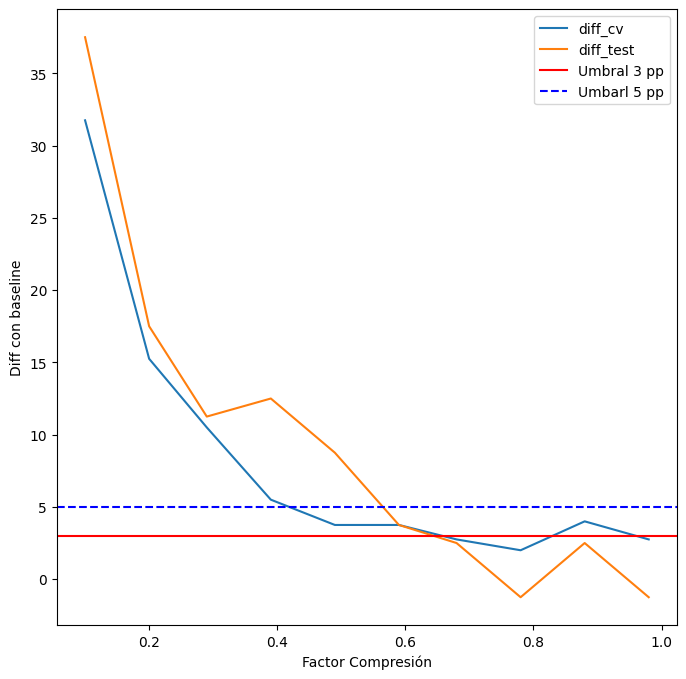

In [26]:


plt.figure(figsize=(8,8))
umbral_corte_1 = 3
umbral_corte_2 = 5
for lineas in ["diff_cv","diff_test"]:
    plt.plot(df_resultados["factor compresión"], df_resultados[lineas], label = lineas)
plt.xlabel("Factor Compresión")
plt.ylabel("Diff con baseline")
plt.axhline(y = umbral_corte_1, color = 'r', linestyle = '-', label = f"Umbral {umbral_corte_1} pp")
plt.axhline(y = umbral_corte_2, color = "b", linestyle = "--",label = f"Umbarl {umbral_corte_2} pp")

plt.legend()



In [27]:
cumple_umbral_1 = (df_resultados["diff_cv"] <= umbral_corte_1) & (df_resultados["diff_test"] <= umbral_corte_1)
df_resultados[cumple_umbral_1]

,num_pca,factor compresión,eval_cv,baseline_cv,diff_cv,eval_test,baseline_test,diff_test
6,28,0.68,90.75,93.5,2.75,92.50,95.0,2.50
7,32,0.78,91.50,93.5,2.00,96.25,95.0,-1.25
9,40,0.98,90.75,93.5,2.75,96.25,95.0,-1.25


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

In [28]:
def pinta_caras(faces,n_cols = 5, title = ""):
    faces = faces.reshape(-1, 64, 64)
    n_rows = ((len(faces) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 4, n_rows * 4.4))
    for index, face in enumerate(faces):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
    plt.title(title)
    plt.show()

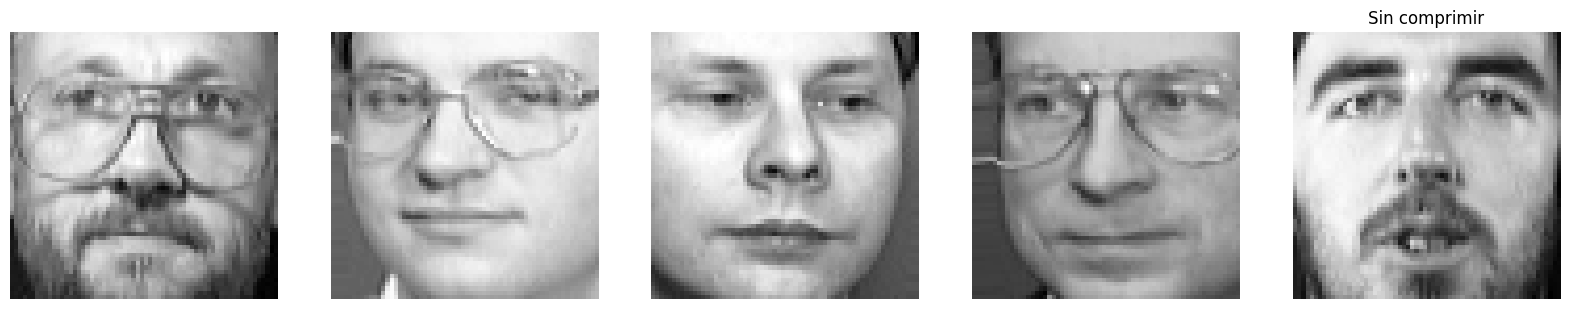

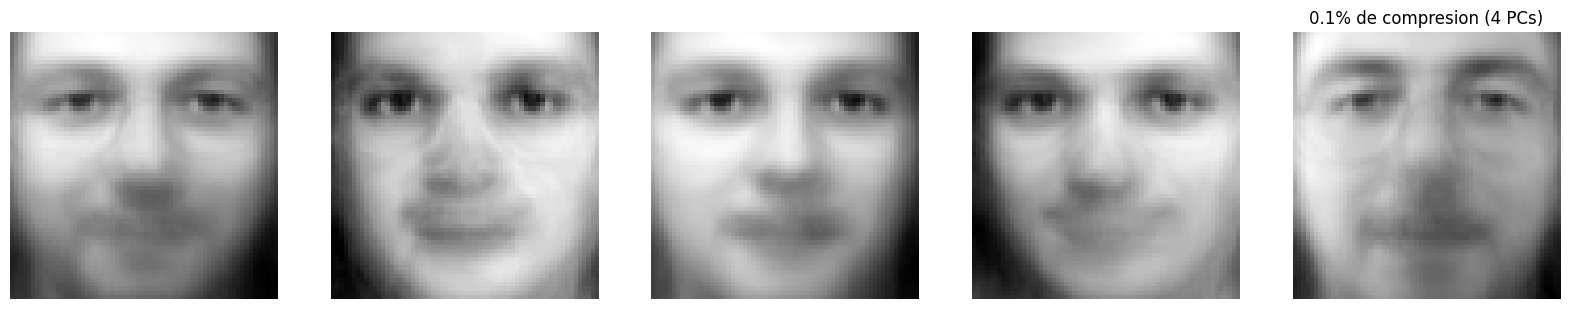

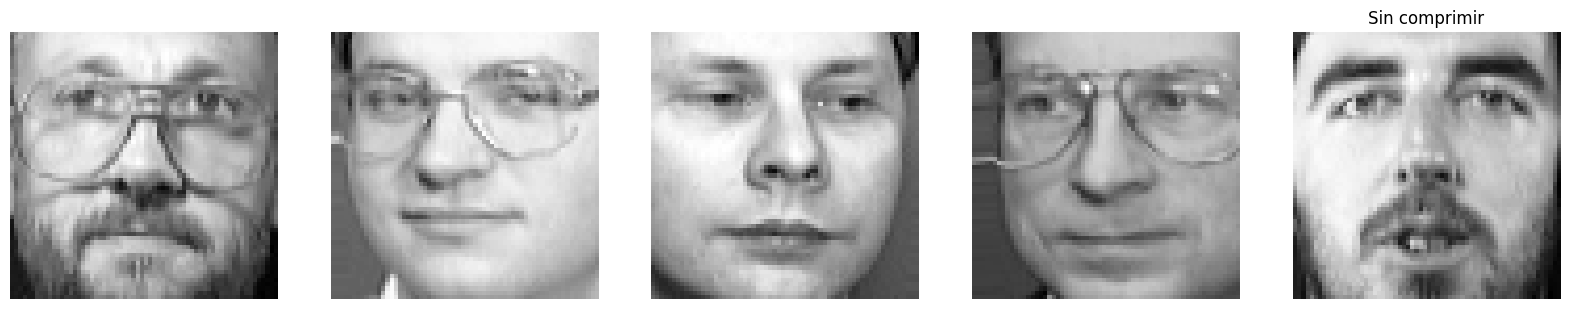

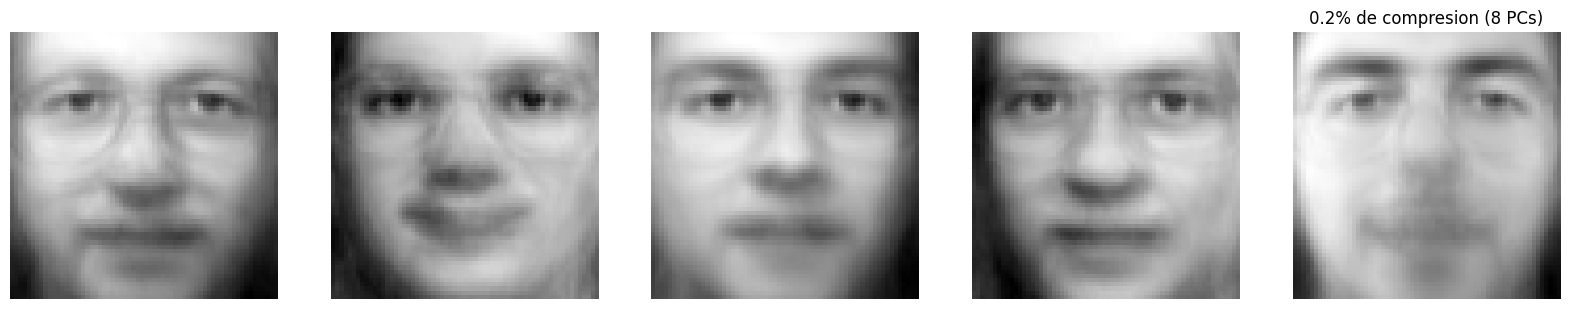

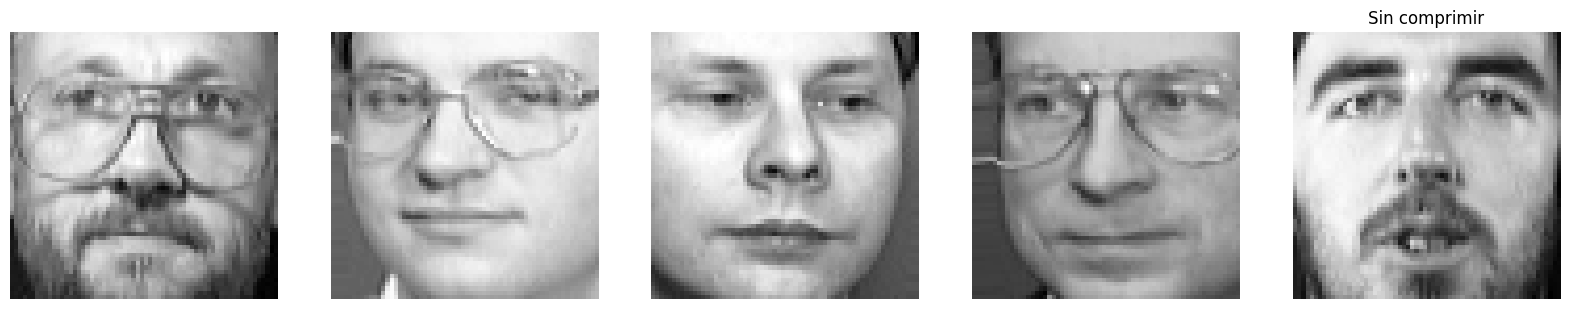

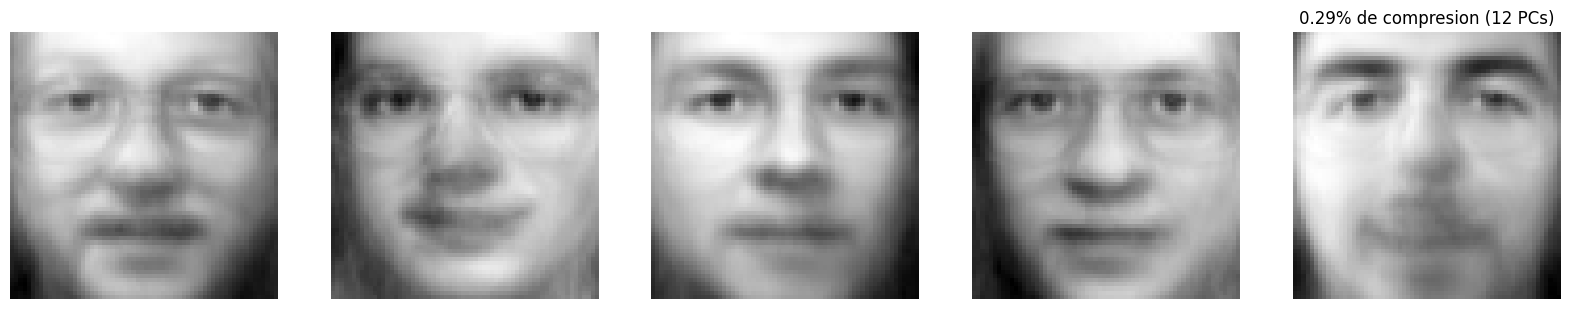

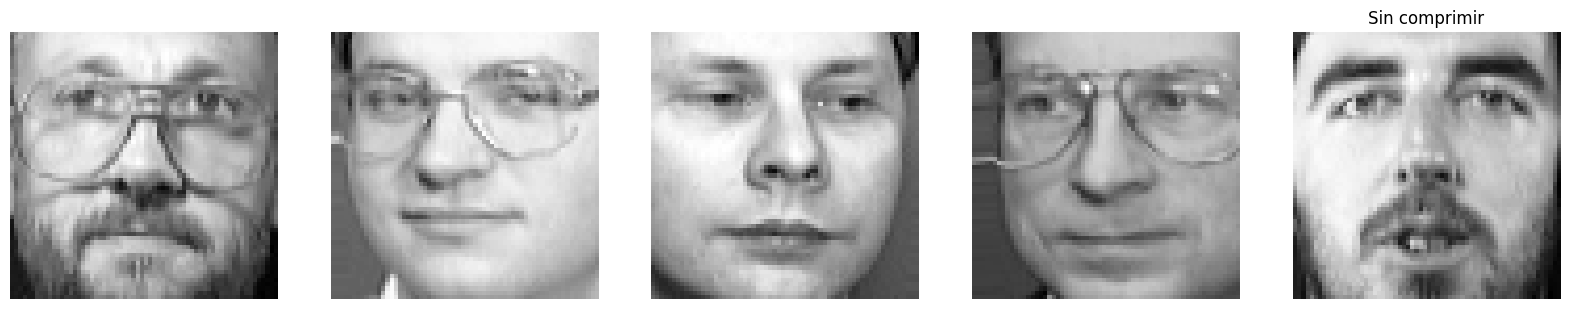

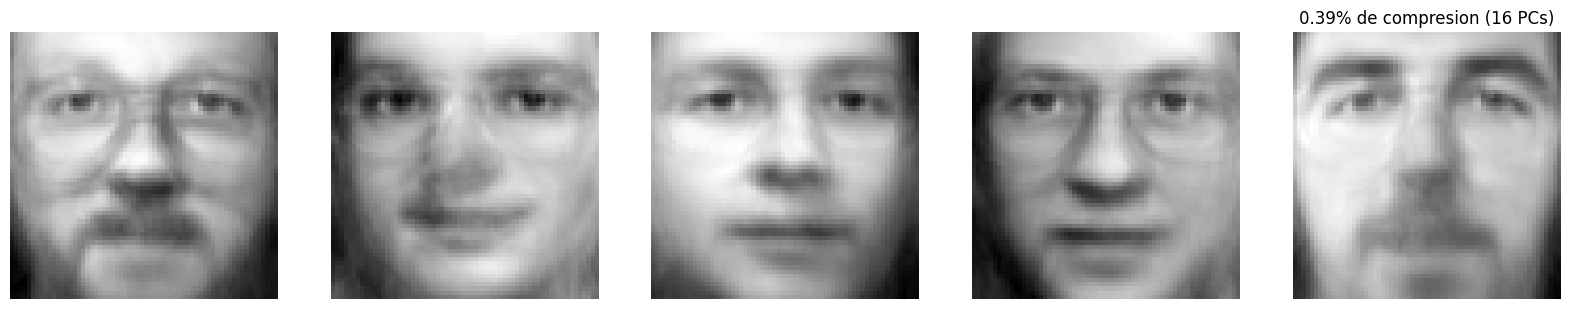

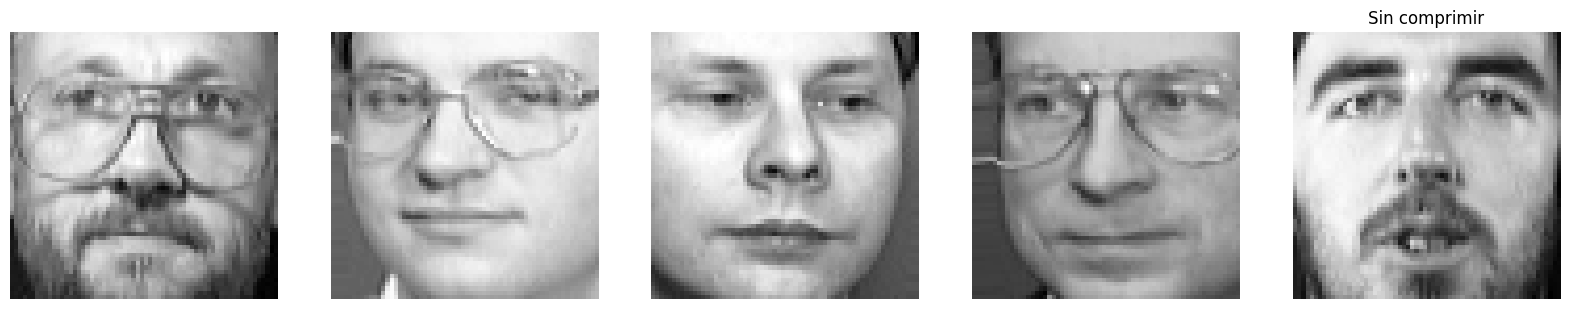

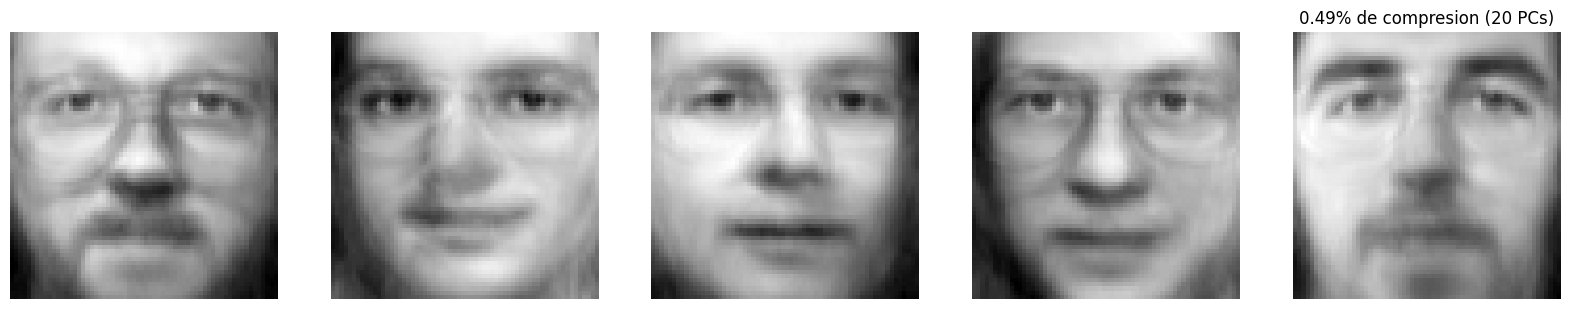

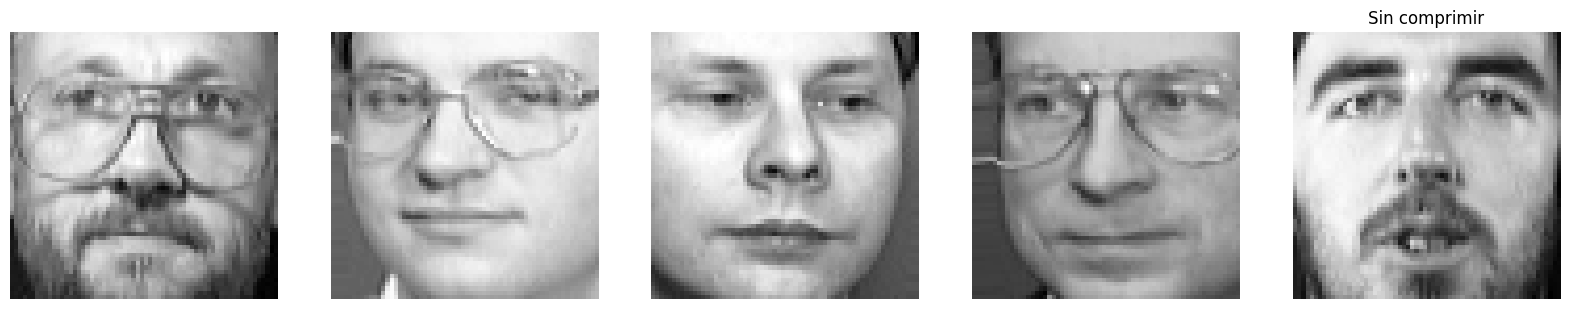

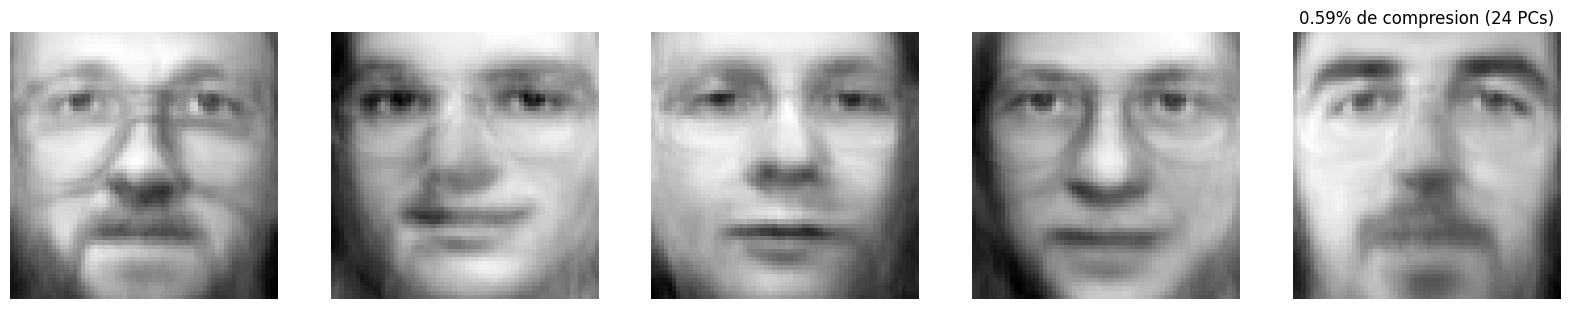

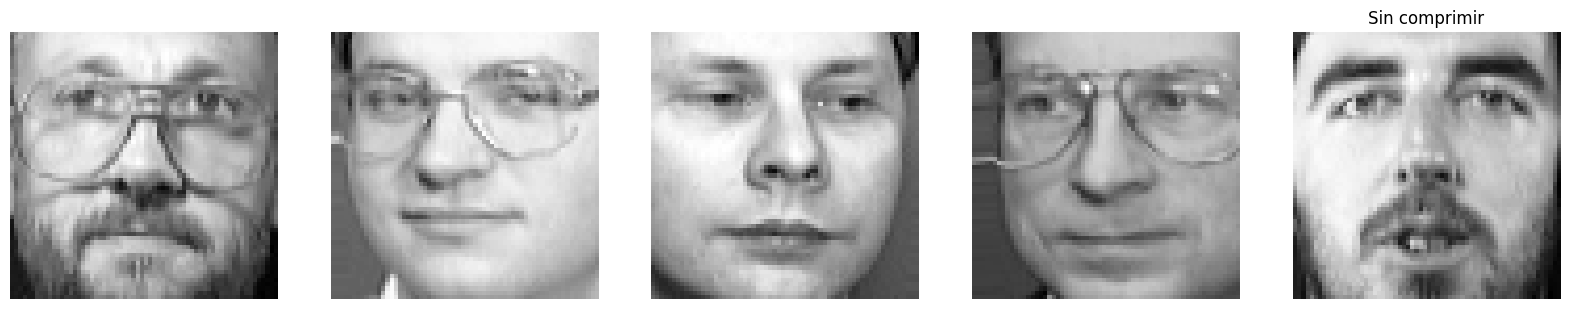

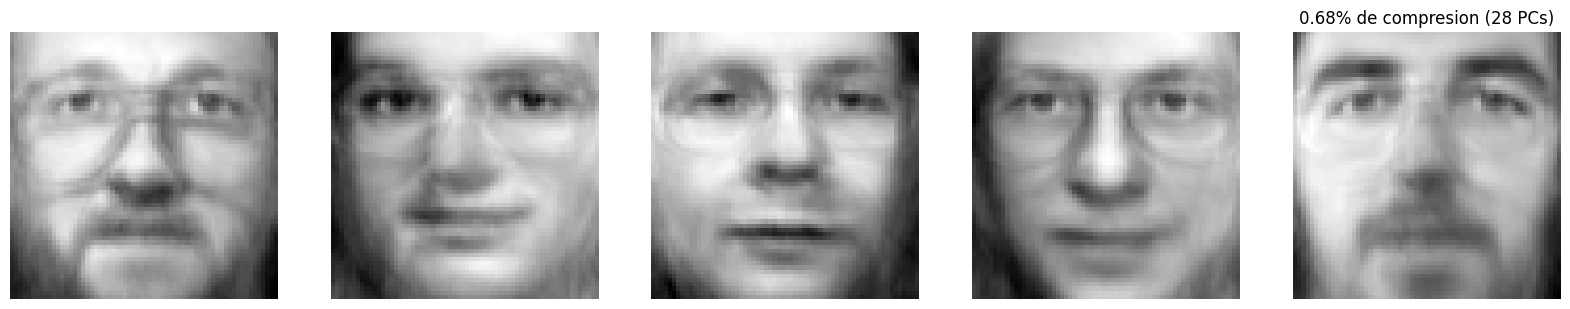

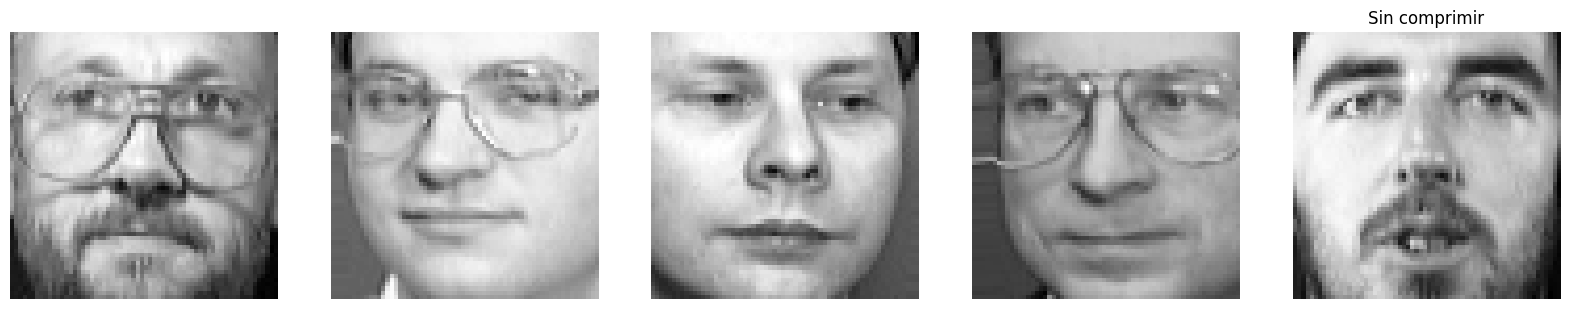

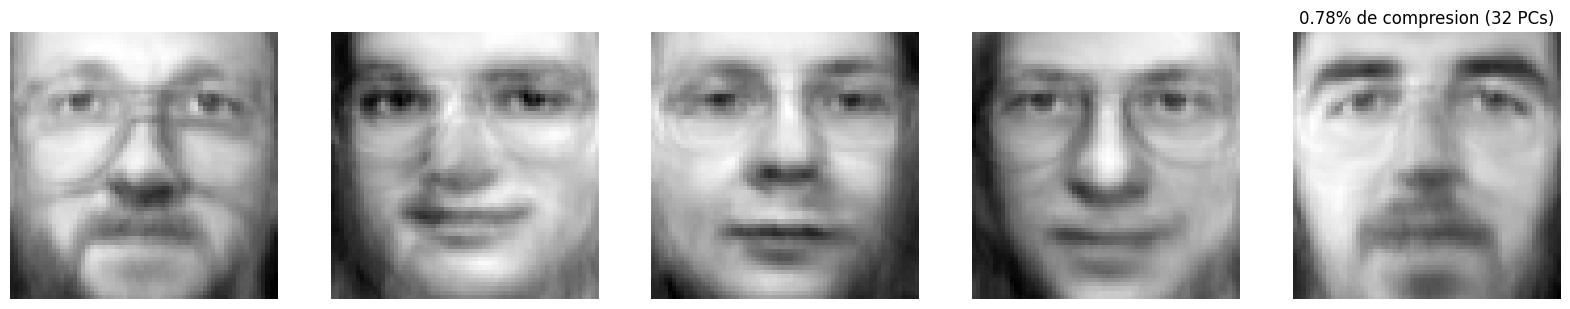

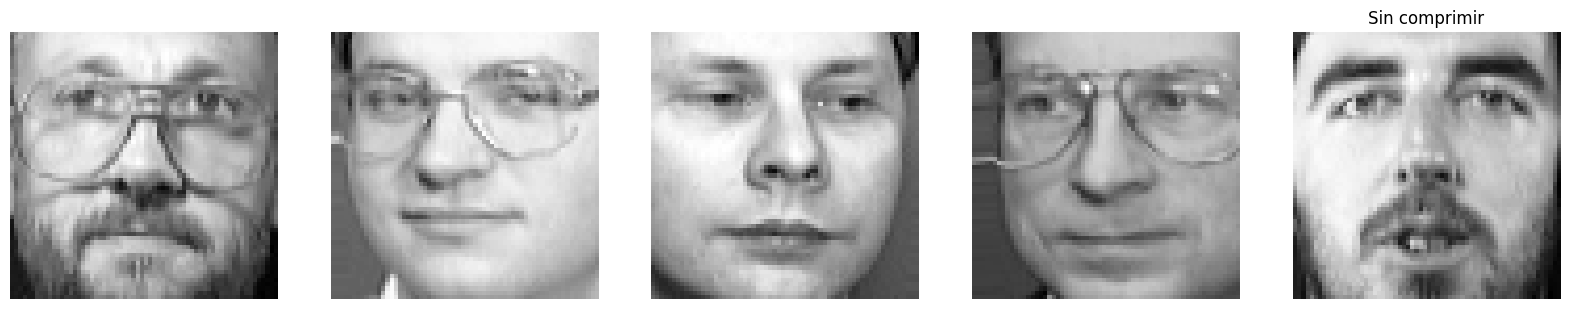

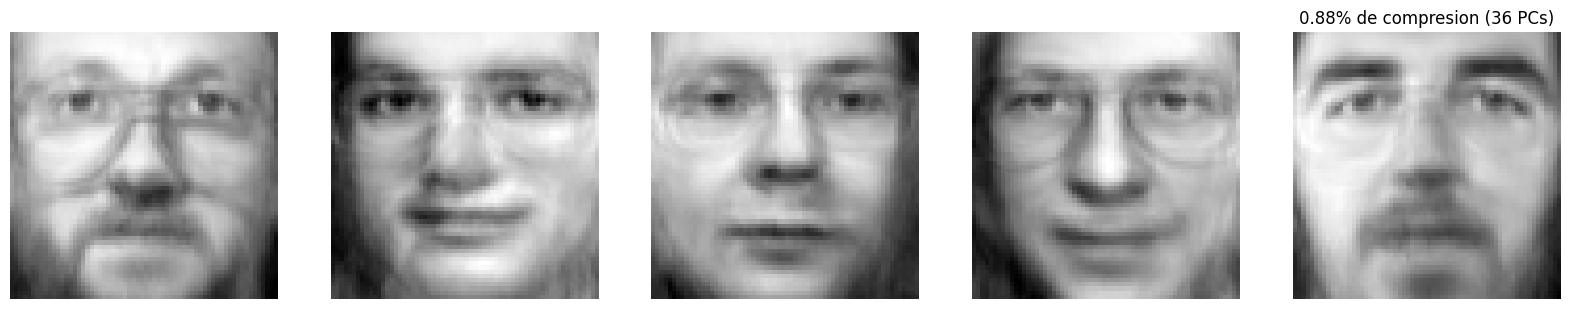

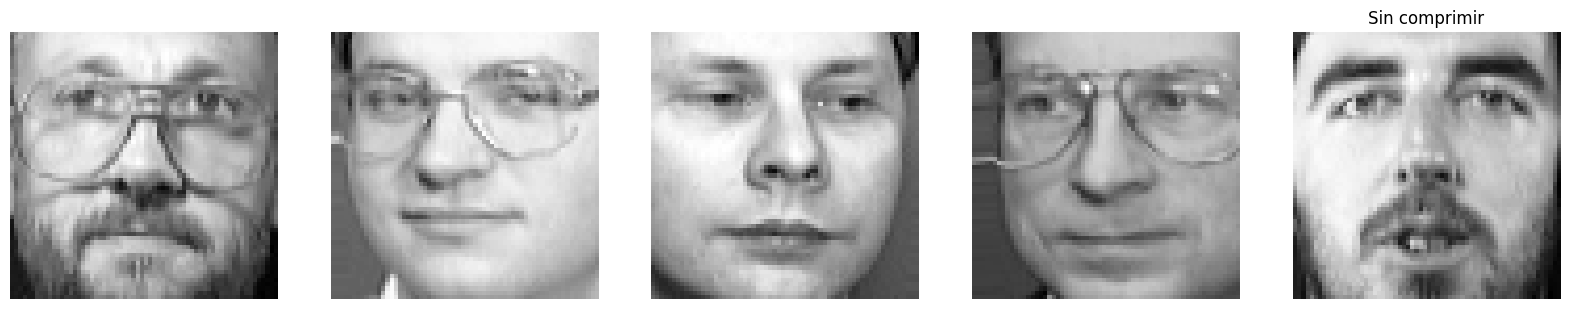

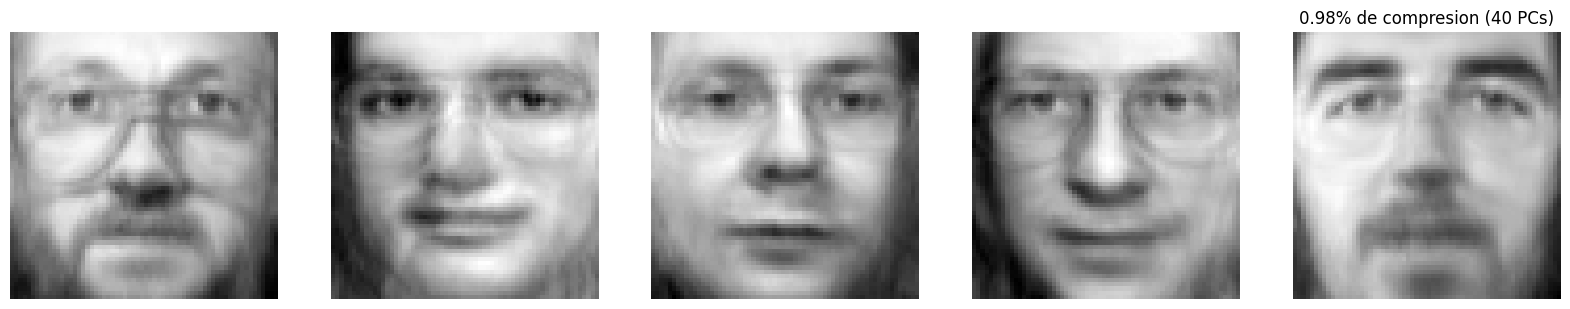

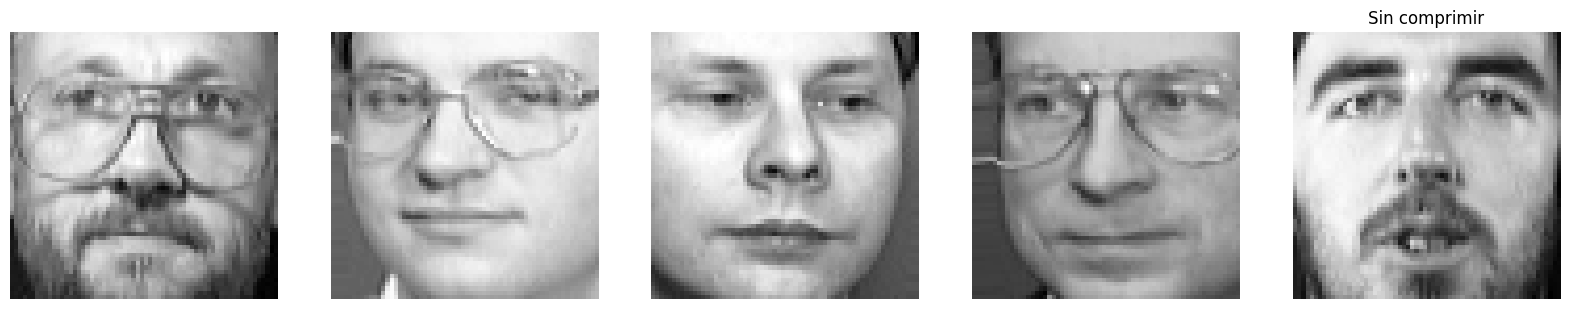

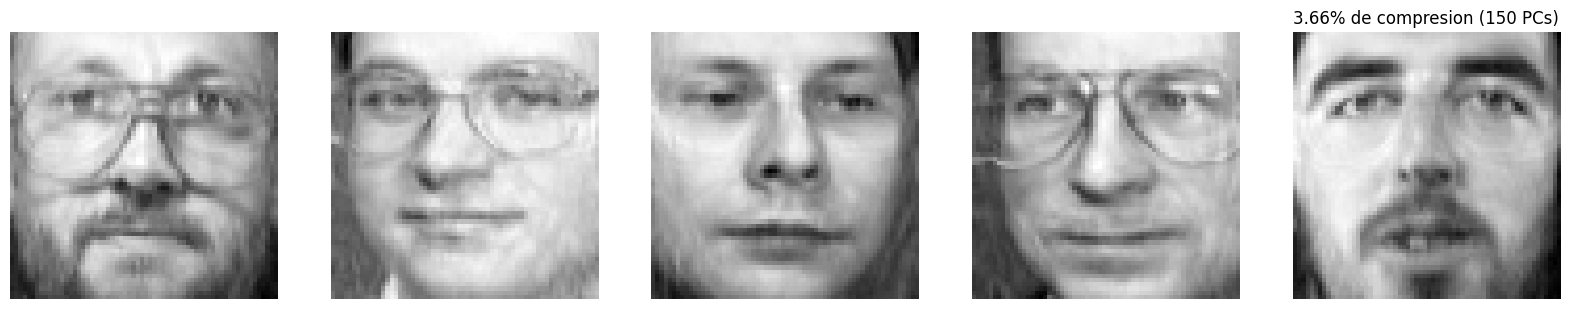

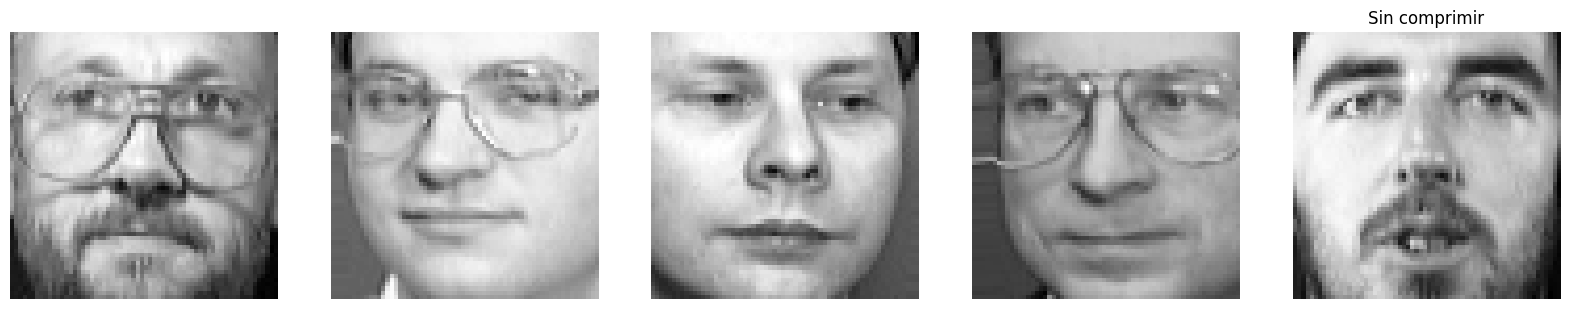

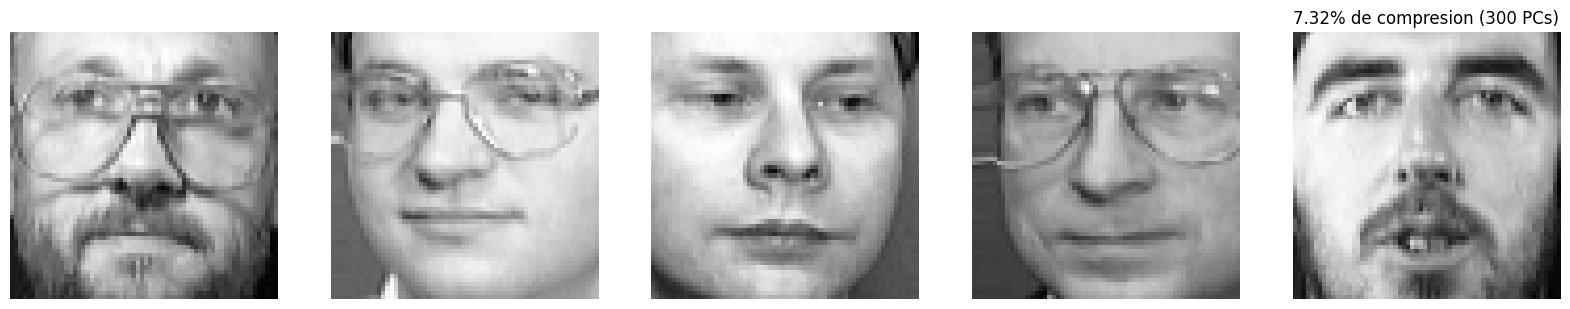

In [29]:
for num_pca in num_pcas + [150,300]: # Añdimos 2 más para que se vea que son las mismas caras :-D
    pca_temp = PCA(num_pca) # Por una cuestión de funcionamiento de la clase PCA tenemos que "comprimir" de nuevo no podemos usar el X_train_pca directamente
    X = pca_temp.fit_transform(X_train)
    X_train_temp = pca_temp.inverse_transform(X) # AQUI ESTA LA CLAVE, primero nos quedamos con el dataset pequeño y luego "descomprimimos"
    pinta_caras(X_train[0:5].values, title = "Sin comprimir")
    pinta_caras(X_train_temp[0:5], title = f"{round(num_pca/num_features*100,2)}% de compresion ({num_pca} PCs)")

